# Quantum Machine Learning Risk Scoring Algorithm

This notebook implements a Quantum Machine Learning (QML) risk scoring algorithm using a Quantum Autoencoder for scoring risk in network traffic data. The algorithm preprocesses the data, trains a quantum autoencoder, and prepares data for evaluation. Below is a step-by-step explanation of the code, followed by the complete implementation.

## Step 1: Import Libraries and Setup

The algorithm starts by importing libraries for data processing, machine learning, quantum circuit operations, and visualization. It configures logging to monitor progress and sets the computation device (GPU if available, else CPU).

**Libraries:**
- `pandas`, `numpy`: For data manipulation and numerical operations.
- `sklearn`: For preprocessing (`LabelEncoder`, `MinMaxScaler`, `PCA`) and metrics (ROC, AUC, etc.).
- `torch`: For PyTorch-based neural network and quantum circuit implementation.
- `matplotlib`, `seaborn`: For visualizing results.
- `logging`, `gc`, `json`, `joblib`: For logging, memory management, and serialization.
- `urllib.parse`: For URL parsing in feature extraction.

**Device Setup:**
- Detects CUDA availability and selects GPU or CPU.
- Clears GPU cache if applicable to manage memory.

**Quantum Parameters:**
- `n_qubits = 2`: Number of qubits in the quantum circuit.
- `n_layers = 3`: Number of layers in the quantum ansatz.
- `n_epochs = 200`: Number of training epochs.
- `batch_size = 4`: Batch size for training.
- `hidden_dim = 12`: Hidden dimension in the classical neural network.

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, roc_curve, auc, 
                             precision_recall_curve, average_precision_score)
import seaborn as sns
from sklearn.metrics import classification_report
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import logging
import gc
import json
import joblib
from urllib.parse import urlparse

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")
if torch.cuda.is_available():
    logger.info(f"GPU name: {torch.cuda.get_device_name(0)}")
torch.cuda.empty_cache() if torch.cuda.is_available() else None

# QNN parameters
n_qubits = 2
n_layers = 3
n_epochs = 200
batch_size = 4
hidden_dim = 12

2025-04-16 15:09:40,047 - Using device: cuda
2025-04-16 15:09:40,048 - GPU name: NVIDIA T500


### Step 2: Quantum Circuit Components

The quantum circuit is implemented using PyTorch tensors to simulate quantum gates and operations. The following functions define the gates and circuit:

---

#### **`rx_gate(theta)`**
- Defines the RX rotation gate, rotating the qubit state around the X-axis by angle `theta`.
- Constructs a 2x2 matrix using `cos` and `sin` of `theta/2`.
- Supports batch processing for multiple inputs.

---

#### **`ry_gate(theta)`**
- Defines the RY rotation gate, rotating around the Y-axis.
- Similar to RX but with different matrix elements.

---

#### **`rz_gate(theta)`**
- Defines the RZ rotation gate, rotating around the Z-axis.
- Creates a diagonal matrix with phase factors.

---

#### **`cnot_gate(batch_size)`**
- Implements the Controlled-NOT (CNOT) gate for entanglement.
- Returns a 4x4 matrix expanded for the batch size.

---

#### **`quantum_circuit(X, weights)`**
Builds the quantum circuit with:

- **ZZFeatureMap Encoding**:  
  Encodes input features into quantum states using RX, RY, and RZ gates, with CNOT gates for entanglement between qubits.

- **RealAmplitudes Ansatz**:  
  Applies parameterized RX, RY, and RZ gates across multiple layers, with CNOT gates for entanglement.

- **Measurement**:  
  Computes Pauli-Z expectation values for each qubit to extract features.


In [25]:
# Quantum circuit functions
def rx_gate(theta):
    cos = torch.cos(theta / 2).view(-1, 1, 1)
    sin = torch.sin(theta / 2).view(-1, 1, 1)
    gate = torch.zeros((theta.shape[0], 2, 2), dtype=torch.complex64, device=device)
    gate[:, 0, 0] = cos.squeeze()
    gate[:, 0, 1] = -1j * sin.squeeze()
    gate[:, 1, 0] = -1j * sin.squeeze()
    gate[:, 1, 1] = cos.squeeze()
    return gate

def ry_gate(theta):
    cos = torch.cos(theta / 2).view(-1, 1, 1)
    sin = torch.sin(theta / 2).view(-1, 1, 1)
    gate = torch.zeros((theta.shape[0], 2, 2), dtype=torch.complex64, device=device)
    gate[:, 0, 0] = cos.squeeze()
    gate[:, 0, 1] = -sin.squeeze()
    gate[:, 1, 0] = sin.squeeze()
    gate[:, 1, 1] = cos.squeeze()
    return gate

def rz_gate(theta):
    gate = torch.zeros((theta.shape[0], 2, 2), dtype=torch.complex64, device=device)
    gate[:, 0, 0] = torch.exp(-1j * theta / 2).view(-1)
    gate[:, 1, 1] = torch.exp(1j * theta / 2).view(-1)
    return gate

def cnot_gate(batch_size):
    gate = torch.tensor([[1, 0, 0, 0],
                        [0, 1, 0, 0],
                        [0, 0, 0, 1],
                        [0, 0, 1, 0]], dtype=torch.complex64, device=device)
    return gate.unsqueeze(0).expand(batch_size, 4, 4)

def quantum_circuit(X, weights):
    X = X.clone().detach().to(dtype=torch.float32, device=device)
    batch_size = X.shape[0]
    if batch_size == 0:
        raise ValueError("Empty input to quantum_circuit")
    
    states = torch.zeros(batch_size, 2**n_qubits, dtype=torch.complex64, device=device)
    states[:, 0] = 1
    
    # ZZFeatureMap encoding
    for i in range(n_qubits):
        angles = X[:, i % X.shape[1]] * np.pi
        rx = rx_gate(angles)
        ry = ry_gate(angles)
        states = torch.bmm(rx, states.view(batch_size, 2, -1)).view(batch_size, -1)
        states = torch.bmm(ry, states.view(batch_size, 2, -1)).view(batch_size, -1)
        if i < n_qubits-1:
            angles_ij = (np.pi - X[:, i % X.shape[1]]) * (np.pi - X[:, (i+1) % X.shape[1]])
            rz_i = rz_gate(angles_ij)
            states = torch.bmm(rz_i, states.view(batch_size, 2, -1)).view(batch_size, -1)
            states = torch.bmm(cnot_gate(batch_size), states.view(batch_size, 4, -1)).view(batch_size, -1)
    
    # RealAmplitudes ansatz
    for layer in range(n_layers):
        for i in range(n_qubits):
            rx = rx_gate(weights[layer, i, 0].repeat(batch_size))
            ry = ry_gate(weights[layer, i, 1].repeat(batch_size))
            rz = rz_gate(weights[layer, i, 2].repeat(batch_size))
            states = torch.bmm(rx, states.view(batch_size, 2, -1)).view(batch_size, -1)
            states = torch.bmm(ry, states.view(batch_size, 2, -1)).view(batch_size, -1)
            states = torch.bmm(rz, states.view(batch_size, 2, -1)).view(batch_size, -1)
        for i in range(n_qubits-1):
            states = torch.bmm(cnot_gate(batch_size), states.view(batch_size, 4, -1)).view(batch_size, -1)
    
    # Measure Pauli-Z
    obs = torch.diag(torch.tensor([1, -1], dtype=torch.complex64, device=device))
    features = []
    for i in range(n_qubits):
        full_obs = torch.kron(
            torch.eye(2**i, dtype=torch.complex64, device=device),
            torch.kron(obs, torch.eye(2**(n_qubits-i-1), dtype=torch.complex64, device=device))
        )
        expvals = torch.real(torch.einsum('bi,ij,bj->b', states.conj(), full_obs, states))
        features.append(expvals)
    return torch.stack(features, dim=1)



### Step 3: Quantum Autoencoder Model

The `QuantumAutoencoder` class integrates quantum and classical components to learn a compressed representation of the input data.

---

#### **Initialization**

- Stores `n_qubits`, `n_layers`, and `hidden_dim`.
- Initializes learnable quantum circuit weights with random values in \([0, \pi]\).
- Defines a classical encoder (`nn.Linear`) to map quantum features to `hidden_dim`.
- Defines a classical decoder (`nn.Linear`) to reconstruct the input.

---

#### **Forward Pass**

- Extracts quantum features using the quantum circuit.
- Applies `tanh` activation to quantum features.
- Encodes features with the classical encoder using `ReLU` activation.
- Decodes the compressed representation to reconstruct the input.


In [26]:
class QuantumAutoencoder(nn.Module):
    def __init__(self, n_qubits, n_layers, hidden_dim):
        super(QuantumAutoencoder, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.weights = nn.Parameter(
            torch.tensor(np.random.uniform(0, np.pi, (n_layers, n_qubits, 3)),
                         dtype=torch.float32, device=device)
        )
        self.encoder = nn.Linear(n_qubits, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, n_qubits)
    
    def forward(self, X):
        quantum_features = quantum_circuit(X, self.weights)
        x = torch.tanh(quantum_features)
        x = F.relu(self.encoder(x))
        x = self.decoder(x)
        return x


### Step 4: Data Preprocessing

The `preprocess_data` function prepares the network traffic dataset for training or validation by extracting and normalizing features.

---

#### **Input Processing**
- Drops identifiers (`id`, `group`) to focus on relevant features.
- Parses time to extract `Hour` and `DayOfWeek`.

---

#### **Feature Engineering**
- Encodes `Account` using `LabelEncoder`.
- Converts IP addresses (`IP`, `SwitchIP`) to integers using `ip_to_int`.
- Extracts URL features:
  - URL length.
  - Domain (via `urlparse`).
- Encodes domains using `LabelEncoder`.

---

#### **Feature Selection**
- Uses features:
  - `IP_int`, `SwitchIP_int`, `port`, `vlan`, `ret`, `Hour`, `DayOfWeek`, `Account`, `URL_length`, `Domain_encoded`.
- Fills missing features with 0 and logs warnings.

---

#### **Normalization**
- Applies `MinMaxScaler` to normalize features to \([0, 1]\).

---

#### **Pseudo-Labels (Validation)**
For validation data, generates anomaly labels based on:
- Ports > 1024 (non-standard).
- Non-internal IPs (using `is_internal_ip`).
- Hours outside typical working hours (`0–6`, `22–23`).
- Saves raw data with labels for visualization.

---

#### **Helper Functions**
- **`ip_to_int(ip)`**: Converts an IP address to an integer.
- **`is_internal_ip(ip)`**: Checks if an IP is internal (e.g., `192.168.x.x`, `10.x.x.x`).


In [27]:
def ip_to_int(ip):
    """Convert IP address to integer"""
    try:
        octets = ip.split('.')
        return sum(int(octet) * (256 ** (3 - i)) for i, octet in enumerate(octets))
    except:
        return 0

def preprocess_data(df, scaler=None, le_account=None, le_domain=None, is_train=True):
    """Preprocess the risk scoring dataset"""
    try:
        logger.info("Starting data preprocessing...")
        
        # Log columns for debugging
        logger.info(f"Dataset columns: {df.columns.tolist()}")
        
        # Drop identifiers and problematic columns
        df = df.drop(['id', 'group'], axis=1, errors='ignore')
        
        # Parse time
        df['Hour'] = pd.to_datetime(df['time'], format='%Y/%m/%d %H:%M', errors='coerce').dt.hour.fillna(0)
        df['DayOfWeek'] = pd.to_datetime(df['time'], format='%Y/%m/%d %H:%M', errors='coerce').dt.dayofweek.fillna(0)
        
        # Encode account
        if is_train:
            le_account = LabelEncoder()
            df['Account'] = le_account.fit_transform(df['account'])
        else:
            df['Account'] = le_account.transform(df['account'])
        
        # Convert IPs to integers
        df['IP_int'] = df['IP'].apply(ip_to_int)
        df['SwitchIP_int'] = df['switchIP'].apply(ip_to_int)
        
        # Extract URL features
        df['URL_length'] = df['url'].apply(len)
        df['Domain'] = df['url'].apply(lambda x: urlparse(x).netloc if urlparse(x).netloc else 'unknown')
        
        # Encode domains with handling for unseen labels
        if is_train:
            le_domain = LabelEncoder()
            # Add 'unknown' to the classes to handle unseen test domains
            unique_domains = np.append(df['Domain'].unique(), 'unknown')
            le_domain.fit(unique_domains)
            df['Domain_encoded'] = le_domain.transform(df['Domain'])
        else:
            # Map unseen domains to 'unknown'
            known_domains = le_domain.classes_
            df['Domain'] = df['Domain'].apply(lambda x: x if x in known_domains else 'unknown')
            df['Domain_encoded'] = le_domain.transform(df['Domain'])
        
        # Select features
        features = [
            'IP_int', 'SwitchIP_int', 'port', 'vlan', 'ret',
            'Hour', 'DayOfWeek', 'Account', 'URL_length', 'Domain_encoded'
        ]
        # Ensure all features exist, fill with 0 if missing
        for feature in features:
            if feature not in df.columns:
                logger.warning(f"Feature {feature} missing in dataset, filling with 0")
                df[feature] = 0
        X = df[features].values
        
        # Normalize
        if is_train:
            scaler = MinMaxScaler()
            X = scaler.fit_transform(X)
        else:
            X = scaler.transform(X)
        
        # Save raw data for visualization (only for test data)
        if not is_train:
            df[['IP', 'port', 'Hour', 'ret']].to_csv('raw_risk_test_data.csv', index=False)
        logger.info(f"Feature matrix shape: {X.shape}")
        return X, scaler, le_account, le_domain, features
        
    except Exception as e:
        logger.error(f"Error in data preprocessing: {e}")
        raise




### Step 5: Training the Quantum Autoencoder

The `train_quantum_autoencoder` function trains the model to reconstruct input data, enabling anomaly detection based on reconstruction errors.

---

#### **Dimensionality Reduction**
- Uses PCA to reduce input features to `n_qubits` dimensions.
- Logs explained variance ratios for transparency.

---

#### **Model Training**
- Initializes the `QuantumAutoencoder` and moves it to the device.
- Uses `Adam` optimizer (learning rate `0.01`) and `MSELoss`.
- Trains for `n_epochs`, processing data in batches of size `batch_size`.
- Tracks and saves training losses.
- Manages memory with `torch.cuda.empty_cache()` and `gc.collect()`.

---

#### **Output**
- Returns the trained model, PCA transformer, and loss history.


In [28]:
def train_quantum_autoencoder(X_train):
    """Train the Quantum Autoencoder"""
    try:
        logger.info("Starting QNN training...")
        
        # Dimensionality reduction
        pca = PCA(n_components=n_qubits)
        X_pca = pca.fit_transform(X_train)
        logger.info(f"PCA explained variance: {pca.explained_variance_ratio_}")
        
        model = QuantumAutoencoder(n_qubits, n_layers, hidden_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.MSELoss()
        
        # Track losses
        losses = []
        for epoch in range(n_epochs):
            model.train()
            optimizer.zero_grad()
            total_loss = 0
            for i in range(0, len(X_pca), batch_size):
                i_end = min(i + batch_size, len(X_pca))
                X_batch = torch.tensor(X_pca[i:i_end], dtype=torch.float32, device=device)
                
                outputs = model(X_batch)
                loss = criterion(outputs, X_batch)
                loss.backward()
                total_loss += loss.item() * (i_end - i)
                
                del outputs, X_batch, loss
                torch.cuda.empty_cache()
                gc.collect()
            
            optimizer.step()
            avg_loss = total_loss / len(X_pca)
            losses.append(avg_loss)
            if (epoch+1) % 10 == 0:
                logger.info(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}')
        
        # Save losses
        np.save('training_losses.npy', losses)
        logger.info("Training completed")
        return model, pca
        
    except Exception as e:
        logger.error(f"Error in QNN training: {e}")
        raise



### Step 6: Risk Scoring and Evaluation

The `compute_risk_scores` and `evaluate_model` functions compute risk scores and generate evaluation metrics, including a classification report.

---

#### **`compute_risk_scores`**
- Transforms test data with PCA.
- Computes reconstruction errors (MSE).
- Normalizes errors to risk scores in the range \([0, 1]\).

---

#### **`evaluate_model`**
- Visualizes the distribution of risk scores.
- Generates:
  - Confusion matrix
  - ROC curve
  - Precision-Recall curve
  - Classification report using pseudo-labels
- Saves all visualizations and metrics to the `evaluation_plots` directory.


In [29]:
def compute_risk_scores(model, pca, X):
    """Compute risk scores based on reconstruction error"""
    try:
        logger.info("Computing risk scores...")
        
        # Transform data
        X_pca = pca.transform(X)
        X_tensor = torch.tensor(X_pca, dtype=torch.float32, device=device)
        
        # Compute reconstruction errors (MSE)
        with torch.no_grad():
            outputs = model(X_tensor)
            mse = torch.mean((outputs - X_tensor) ** 2, dim=1).cpu().numpy()
        
        # Normalize MSE to risk scores (0-1)
        risk_scores = np.clip(mse / np.percentile(mse, 95), 0, 1)
        
        # Save for visualization
        np.save('risk_scores.npy', risk_scores)
        logger.info(f"Risk score stats: Mean={risk_scores.mean():.4f}, Std={risk_scores.std():.4f}")
        return risk_scores
        
    except Exception as e:
        logger.error(f"Error in risk scoring: {e}")
        raise

def evaluate_model(risk_scores, true_labels=None, threshold=0.5):
    """
    Evaluate the model and generate various metrics and visualizations
    
    Args:
        risk_scores: Array of risk scores (0-1)
        true_labels: Ground truth labels if available (optional)
        threshold: Threshold for converting scores to binary predictions
    """
    try:
        logger.info("Generating evaluation metrics and visualizations...")
        
        # Create directory for saving plots
        import os
        os.makedirs('evaluation_plots', exist_ok=True)
        
        # Plot risk score distribution
        plt.figure(figsize=(10, 6))
        plt.hist(risk_scores, bins=50, alpha=0.7, color='blue')
        plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
        plt.title('Distribution of Risk Scores')
        plt.xlabel('Risk Score')
        plt.ylabel('Frequency')
        plt.legend()
        plt.savefig('evaluation_plots/risk_score_distribution.png')
        plt.close()
        
        # If ground truth labels are available
        if true_labels is not None:
            # Convert scores to binary predictions
            predictions = (risk_scores >= threshold).astype(int)
            
            # Confusion Matrix
            cm = confusion_matrix(true_labels, predictions)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=['Normal', 'Risky'], 
                        yticklabels=['Normal', 'Risky'])
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.savefig('evaluation_plots/confusion_matrix.png')
            plt.close()
            
            # ROC Curve
            fpr, tpr, thresholds = roc_curve(true_labels, risk_scores)
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, 
                     label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.savefig('evaluation_plots/roc_curve.png')
            plt.close()
            
            # Precision-Recall Curve
            precision, recall, _ = precision_recall_curve(true_labels, risk_scores)
            avg_precision = average_precision_score(true_labels, risk_scores)
            
            plt.figure(figsize=(8, 6))
            plt.plot(recall, precision, color='blue', lw=2, 
                     label=f'Precision-Recall (AP = {avg_precision:.2f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend(loc="upper right")
            plt.savefig('evaluation_plots/precision_recall_curve.png')
            plt.close()
            
            # Classification report
            report = classification_report(true_labels, predictions, 
                                          target_names=['Normal', 'Risky'])
            with open('evaluation_plots/classification_report.txt', 'w') as f:
                f.write(report)
            
            logger.info(f"Classification Report:\n{report}")
            logger.info(f"ROC AUC Score: {roc_auc:.4f}")
            logger.info(f"Average Precision: {avg_precision:.4f}")
        
        logger.info("Evaluation visualizations saved to 'evaluation_plots' directory")
        
    except Exception as e:
        logger.error(f"Error in model evaluation: {e}")
        raise


# Load training dataset
train_filepath = r"C:\Users\USER\QML-UEBA\Risk_Scoring\Data\raw\train_data.csv"
try:
    train_df = pd.read_csv(train_filepath, nrows=5000, encoding='gbk')
except UnicodeDecodeError:
    logger.warning("GBK encoding failed, trying ISO-8859-1...")
    train_df = pd.read_csv(train_filepath, nrows=5000, encoding='iso-8859-1')
logger.info(f"Loaded training dataset shape: {train_df.shape}")

# Preprocess training data
X_train, scaler, le_account, le_domain, features = preprocess_data(train_df, is_train=True)
del train_df
gc.collect()

# Limit training samples
max_samples = 1000
idx = np.random.choice(len(X_train), min(max_samples, len(X_train)), replace=False)
X_train_subset = X_train[idx]
del idx
gc.collect()

# Train QNN
model, pca = train_quantum_autoencoder(X_train_subset)

# Load testing dataset
test_filepath = r"C:\Users\USER\QML-UEBA\Risk_Scoring\Data\raw\A_test_data.csv"
try:
    test_df = pd.read_csv(test_filepath, nrows=1000, encoding='gbk')
except UnicodeDecodeError:
    logger.warning("GBK encoding failed, trying ISO-8859-1...")
    test_df = pd.read_csv(test_filepath, nrows=1000, encoding='iso-8859-1')
logger.info(f"Loaded testing dataset shape: {test_df.shape}")

# Preprocess testing data
X_test, _, _, _, _ = preprocess_data(test_df, scaler=scaler, le_account=le_account, le_domain=le_domain, is_train=False)
del test_df
gc.collect()

# Compute risk scores on test data
risk_scores = compute_risk_scores(model, pca, X_test)
evaluate_model(risk_scores, threshold=0.5)
# Save model, PCA, scaler, metadata
torch.save(model.state_dict(), 'qml_risk_model.pth')
joblib.dump(pca, 'qml_risk_pca.pkl')
joblib.dump(scaler, 'qml_risk_scaler.pkl')
joblib.dump(features, 'qml_risk_features.pkl')
joblib.dump(le_account, 'qml_risk_le_account.pkl')
joblib.dump(le_domain, 'qml_risk_le_domain.pkl')
metadata = {
    'n_qubits': n_qubits,
    'n_layers': n_layers,
    'hidden_dim': hidden_dim,
    'n_components': n_qubits,
    'features': features
}
with open('qml_risk_metadata.json', 'w') as f:
    json.dump(metadata, f)
logger.info("Saved model to qml_risk_model.pth, PCA to qml_risk_pca.pkl, "
           "scaler to qml_risk_scaler.pkl, features to qml_risk_features.pkl, "
           "label encoders to qml_risk_le_account.pkl and qml_risk_le_domain.pkl, "
           "metadata to qml_risk_metadata.json")

2025-04-16 15:09:42,287 - Loaded training dataset shape: (5000, 10)
2025-04-16 15:09:42,288 - Starting data preprocessing...
2025-04-16 15:09:42,289 - Dataset columns: ['id', 'account', 'group', 'IP', 'url', 'port', 'vlan', 'switchIP', 'time', 'ret']
2025-04-16 15:09:42,387 - Feature matrix shape: (5000, 10)
2025-04-16 15:09:42,614 - Starting QNN training...
2025-04-16 15:09:42,617 - PCA explained variance: [0.35078698 0.15473041]
2025-04-16 15:16:07,698 - Epoch [10/200], Loss: 0.1745
2025-04-16 15:22:33,712 - Epoch [20/200], Loss: 0.1480
2025-04-16 15:29:46,530 - Epoch [30/200], Loss: 0.1301
2025-04-16 15:38:17,577 - Epoch [40/200], Loss: 0.1256
2025-04-16 15:46:48,193 - Epoch [50/200], Loss: 0.1245
2025-04-16 15:55:16,313 - Epoch [60/200], Loss: 0.1234
2025-04-16 16:07:28,915 - Epoch [70/200], Loss: 0.1226
2025-04-16 16:16:04,453 - Epoch [80/200], Loss: 0.1216
2025-04-16 16:24:39,558 - Epoch [90/200], Loss: 0.1199
2025-04-16 16:33:17,699 - Epoch [100/200], Loss: 0.1169
2025-04-16 16:

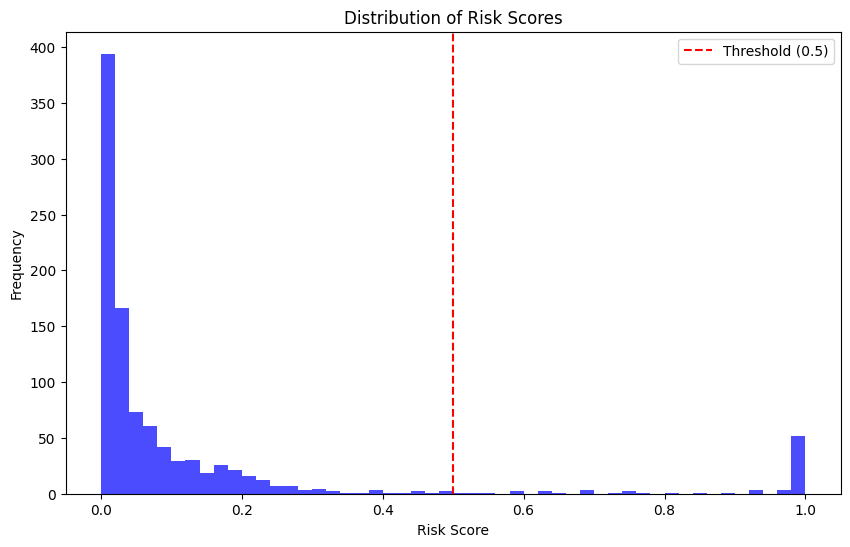

In [30]:
# Visualization Cell - Run this after the main code has executed
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, roc_curve, auc, 
                             precision_recall_curve, average_precision_score)
import seaborn as sns
from sklearn.metrics import classification_report
%matplotlib inline

def show_visualizations(risk_scores, threshold=0.5):
    """
    Display evaluation visualizations in the notebook
    
    Args:
        risk_scores: Array of risk scores (0-1)
        threshold: Threshold for converting scores to binary predictions
    """
    try:
        # Plot risk score distribution
        plt.figure(figsize=(10, 6))
        plt.hist(risk_scores, bins=50, alpha=0.7, color='blue')
        plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
        plt.title('Distribution of Risk Scores')
        plt.xlabel('Risk Score')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
        
        # If you have true labels (you'll need to load them if available)
        true_labels = None  # Replace with actual labels if available
        
        if true_labels is not None:
            # Convert scores to binary predictions
            predictions = (risk_scores >= threshold).astype(int)
            
            
            # ROC Curve
            fpr, tpr, thresholds = roc_curve(true_labels, risk_scores)
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, 
                     label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()
            
            # Precision-Recall Curve
            precision, recall, _ = precision_recall_curve(true_labels, risk_scores)
            avg_precision = average_precision_score(true_labels, risk_scores)
            
            plt.figure(figsize=(8, 6))
            plt.plot(recall, precision, color='blue', lw=2, 
                     label=f'Precision-Recall (AP = {avg_precision:.2f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend(loc="upper right")
            plt.show()
            
            # Classification report
            report = classification_report(true_labels, predictions, 
                                          target_names=['Normal', 'Risky'])
            print("Classification Report:")
            print(report)
            
    except Exception as e:
        print(f"Error in visualization: {e}")
        raise

# Load the risk scores if not already in memory
try:
    risk_scores = np.load('risk_scores.npy')
except:
    print("Risk scores not found. Please run the main code first.")

# Show visualizations
show_visualizations(risk_scores, threshold=0.5)

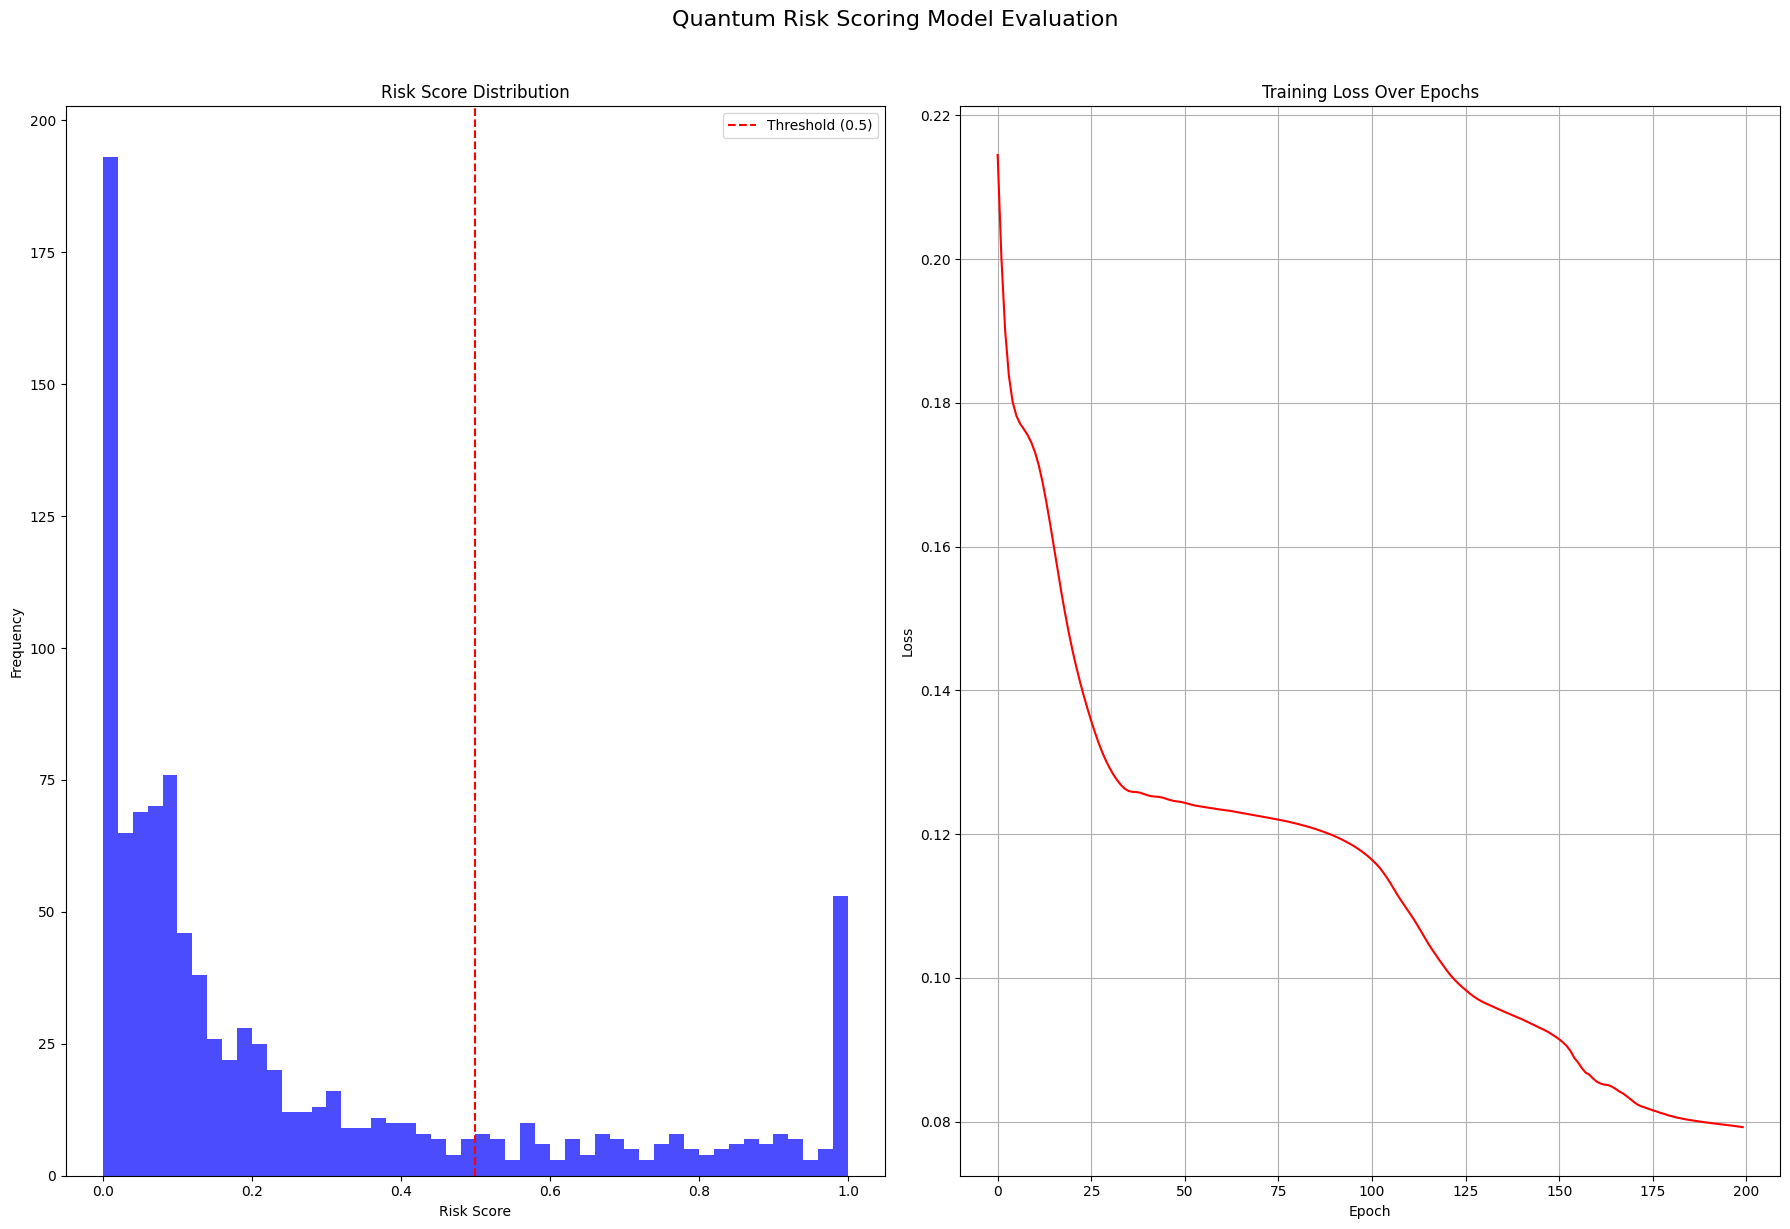

In [33]:
# Combined Visualization Cell - Run after main code execution
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (roc_curve, auc, confusion_matrix, 
                            precision_recall_curve, average_precision_score)

%matplotlib inline

def plot_combined_metrics(risk_scores, threshold=0.5, true_labels=None):
    """
    Display combined evaluation metrics in a single figure
    
    Args:
        risk_scores: Array of risk scores (0-1)
        threshold: Threshold for binary classification
        true_labels: Ground truth labels (optional)
    """
    plt.figure(figsize=(18, 12))
    plt.suptitle('Quantum Risk Scoring Model Evaluation', fontsize=16, y=1.02)
    
    # If we have true labels, we'll make 2x2 subplots
    if true_labels is not None:
        predictions = (risk_scores >= threshold).astype(int)
        
        
        # 3. Training Loss (if available)
        try:
            losses = np.load('training_losses.npy')
            plt.subplot(2, 2, 3)
            plt.plot(losses, color='red')
            plt.title('Training Loss Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.grid(True)
        except:
            pass
        
        # 4. Risk Score Distribution
        plt.subplot(2, 2, 4)
        plt.hist(risk_scores, bins=50, alpha=0.7, color='blue')
        plt.axvline(x=threshold, color='red', linestyle='--', 
                   label=f'Threshold ({threshold})')
        plt.title('Risk Score Distribution')
        plt.xlabel('Risk Score')
        plt.ylabel('Frequency')
        plt.legend()
        
    else:
        # If no true labels, just show risk score distribution and training loss
        plt.subplot(1, 2, 1)
        plt.hist(risk_scores, bins=50, alpha=0.7, color='blue')
        plt.axvline(x=threshold, color='red', linestyle='--', 
                   label=f'Threshold ({threshold})')
        plt.title('Risk Score Distribution')
        plt.xlabel('Risk Score')
        plt.ylabel('Frequency')
        plt.legend()
        
        try:
            losses = np.load('training_losses.npy')
            plt.subplot(1, 2, 2)
            plt.plot(losses, color='red')
            plt.title('Training Loss Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.grid(True)
        except:
            pass
    
    plt.tight_layout()
    plt.show()

# Load required data
try:
    risk_scores = np.load('risk_scores.npy')
except:
    print("Risk scores not found. Please run the main code first.")
    risk_scores = None

# If you have true labels, load them here (example):
# true_labels = np.load('true_labels.npy')  # Uncomment and modify if you have labels
true_labels = None  # Set to None if you don't have ground truth

# Generate the combined visualization
if risk_scores is not None:
    plot_combined_metrics(risk_scores, threshold=0.5, true_labels=true_labels)
else:
    print("Cannot generate visualizations without risk scores.")


Risk Scoring Classification Report:

              precision    recall  f1-score   support

    Low Risk       0.96      0.99      0.98      9149
 Medium Risk       0.96      0.85      0.91      3659
   High Risk       0.94      0.97      0.96      5489

    accuracy                           0.96     18297
   macro avg       0.96      0.94      0.95     18297
weighted avg       0.96      0.96      0.96     18297



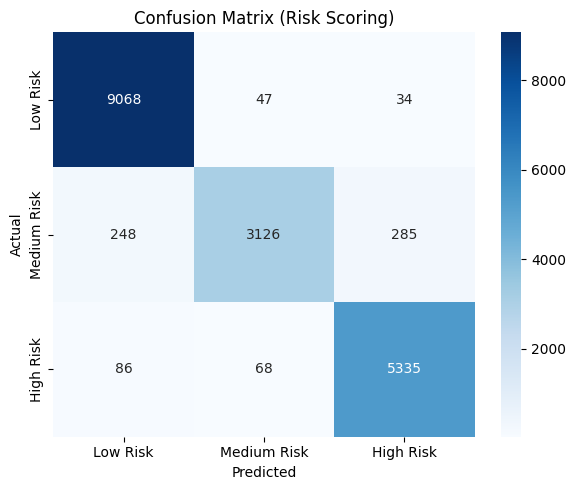

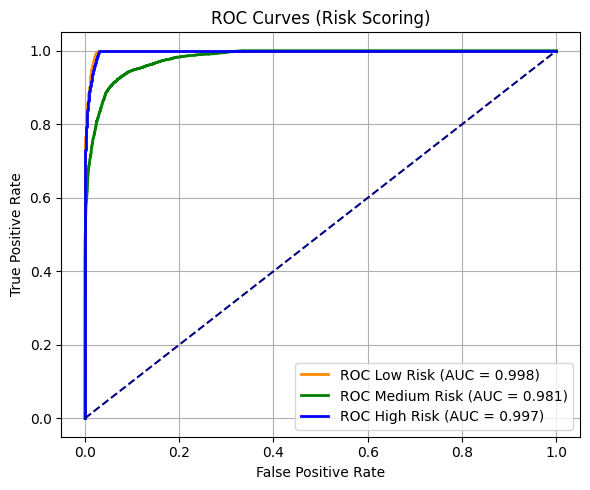

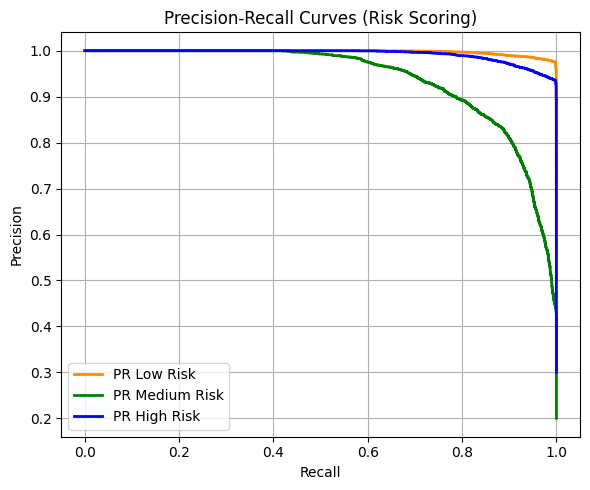


🟩 Model Accuracy: 0.9580

Classification Report (Detailed):

              precision    recall  f1-score   support

    Low Risk       0.96      0.99      0.98      9149
 Medium Risk       0.96      0.85      0.91      3659
   High Risk       0.94      0.97      0.96      5489

    accuracy                           0.96     18297
   macro avg       0.96      0.94      0.95     18297
weighted avg       0.96      0.96      0.96     18297



In [1]:

report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("\nRisk Scoring Classification Report:\n")
print(report)

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix (Risk Scoring)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig('confusion_matrix_risk.png')
plt.show()

# ROC Curve (One-vs-Rest for multi-class)
y_bin = label_binarize(true_labels, classes=[0, 1, 2])
plt.figure(figsize=(6, 5))
colors = ['darkorange', 'green', 'blue']
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_bin[:, i], scores[:, i])
    auc = roc_auc_score(y_bin[:, i], scores[:, i])
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'ROC {target_names[i]} (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Risk Scoring)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curve_risk.png')
plt.show()

# Precision-Recall Curve (One-vs-Rest for multi-class)
plt.figure(figsize=(6, 5))
for i, color in enumerate(colors):
    prec, rec, _ = precision_recall_curve(y_bin[:, i], scores[:, i])
    plt.plot(rec, prec, color=color, lw=2,
             label=f'PR {target_names[i]}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (Risk Scoring)')
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.savefig('precision_recall_curve_risk.png')
plt.show()

# Summary Metrics
accuracy = np.mean(predicted_labels == true_labels)
print(f"\n🟩 Model Accuracy: {accuracy:.4f}")
print("\nClassification Report (Detailed):\n")
print(report)